# Классификатор спам-писем

## Импорт библиотек

In [29]:
import os

import pandas as pd
import numpy as np
import re
import spacy
import random
import joblib

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc

import matplotlib.pyplot as plt
import seaborn as sns

nlp = spacy.load("en_core_web_sm")

## Загрузка данных для обучения и тестирования

In [30]:
dataset_path = "E:/ML_NLP/spam_ham_dataset" 

data = []  

# Проходим по папкам 1/ - 6/

for folder in os.listdir(dataset_path):  
    folder_path = os.path.join(dataset_path, folder)
    
    if os.path.isdir(folder_path):  
        for label in ['spam', 'ham']: 
            label_path = os.path.join(folder_path, label)
            
            if os.path.isdir(label_path):  
                for filename in os.listdir(label_path):  
                    file_path = os.path.join(label_path, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
                            text = f.read()  
                            data.append({'text': text, 'label': label})  
                    except Exception as e:
                        print(f"Ошибка с файлом {file_path}: {e}")

# Превращаем в DataFrame

df = pd.DataFrame(data)  
df.head()  


,text,label
0,Subject: dobmeos with hgh my energy level has ...,spam
1,Subject: your prescription is ready . . oxwq s...,spam
2,Subject: get that new car 8434\npeople nowthe ...,spam
3,"Subject: await your response\ndear partner ,\n...",spam
4,"Subject: coca cola , mbna america , nascar par...",spam


## Функция предобработки текста

In [31]:
def preprocess_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"[^a-zA-Z']", ' ', text)
    text = re.sub(r'^Subject\s*:?[ ]*', '', text, flags=re.IGNORECASE)

    doc = nlp(text.lower())

    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

df['text_cleaned'] = df['text'].apply(preprocess_text)
df[['text', 'text_cleaned']].head()

,text,text_cleaned
0,Subject: dobmeos with hgh my energy level has ...,dobmeo hgh energy level go stukm introduce doc...
1,Subject: your prescription is ready . . oxwq s...,prescription ready oxwq s f e low cost prescri...
2,Subject: get that new car 8434\npeople nowthe ...,new car people nowthe weather climate particul...
3,"Subject: await your response\ndear partner ,\n...",await response dear partner team government of...
4,"Subject: coca cola , mbna america , nascar par...",coca cola mbna america nascar partner otcbb im...


## Векторизация очищенного текста

In [43]:
vectorizer = TfidfVectorizer(max_features=3000)
X = vectorizer.fit_transform(df['text_cleaned'])

y = df['label'].map({'ham': 0, 'spam': 1})

## Деление на обучающую и тестовую выборки

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[0 1]
5927     1
4678     0
29910    1
188      1
22103    0
Name: label, dtype: int64


## Обучение моделей

In [34]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": MultinomialNB(),
    "Random Forest": RandomForestClassifier(),
    "SVM": SVC(probability=True),
    "KNN": KNeighborsClassifier()
}

fitted_models = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    fitted_models[name] = model
    print(f"{name} обучена!")


Logistic Regression обучена!
Naive Bayes обучена!
Random Forest обучена!
SVM обучена!
KNN обучена!


## Сохранение обученных моделей

In [ ]:
if not os.path.exists("models"):
    os.makedirs("models")
    
joblib.dump(vectorizer, "models/tfidf_vectorizer.pkl")
joblib.dump(fitted_models["Logistic Regression"], "models/logreg.pkl")
joblib.dump(fitted_models["SVM"], "models/svm.pkl")
joblib.dump(fitted_models["Naive Bayes"], "models/naive_bayes.pkl")
joblib.dump(fitted_models["Random Forest"], "models/random_forest.pkl")
joblib.dump(fitted_models["KNN"], "models/knn.pkl")

['models/knn.pkl']

## Оценка качаества моделей

In [36]:
for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3334
           1       0.97      0.99      0.98      3409

    accuracy                           0.98      6743
   macro avg       0.98      0.98      0.98      6743
weighted avg       0.98      0.98      0.98      6743


--- Naive Bayes ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      3334
           1       0.97      0.99      0.98      3409

    accuracy                           0.98      6743
   macro avg       0.98      0.98      0.98      6743
weighted avg       0.98      0.98      0.98      6743


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      3334
           1       0.98      0.99      0.98      3409

    accuracy                           0.98      6743
   macro avg       0.98      0.98      0.98      6743
w

## Визуализация результатов
### Матрица ошибок

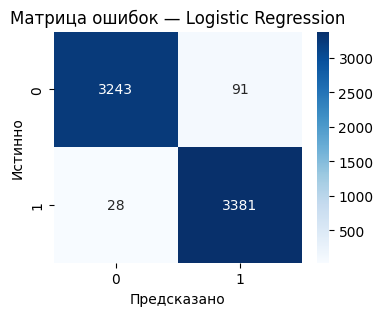

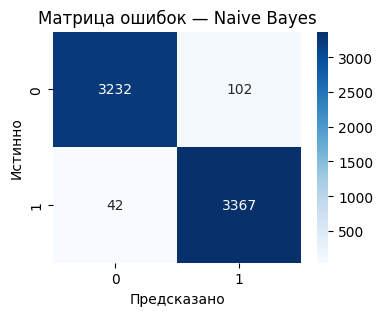

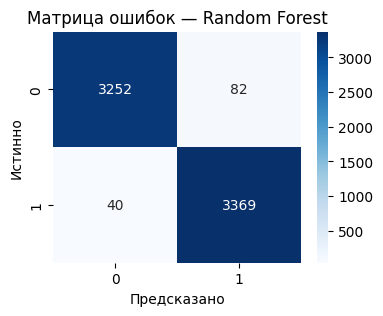

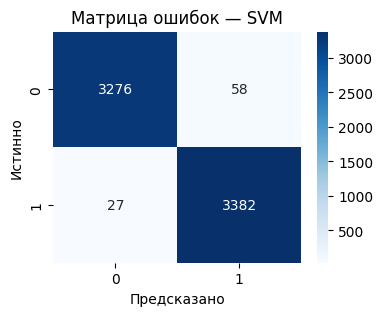

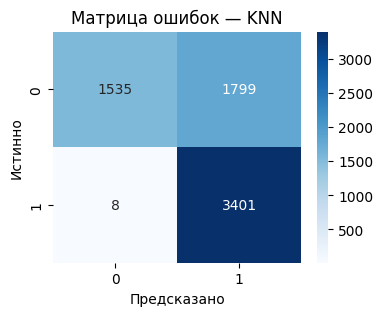

In [37]:
def plot_conf_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Матрица ошибок — {model_name}')
    plt.xlabel('Предсказано')
    plt.ylabel('Истинно')
    plt.show()

for name, model in fitted_models.items():
    y_pred = model.predict(X_test)
    plot_conf_matrix(y_test, y_pred, name)

### Построение ROC-кривой

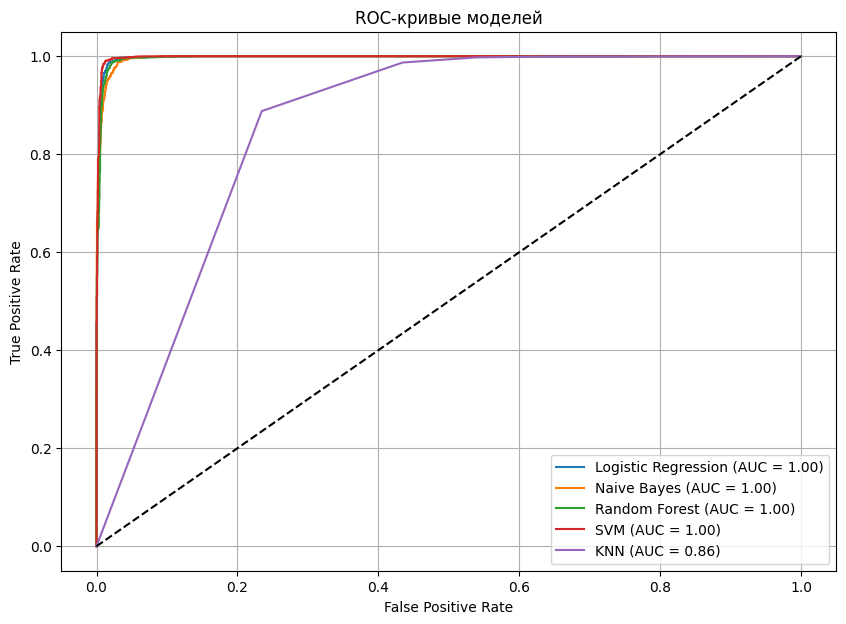

In [38]:
plt.figure(figsize=(10, 7))

for name, model in fitted_models.items():
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1] 
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')  # диагональная линия — случайное угадывание
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривые моделей')
plt.legend(loc='lower right')
plt.grid()
plt.show()


## Визуализация нескольких случайных электорнных писем из тестовой выборки с предсказаниями моделей

In [56]:
sample_indices = random.sample(range(X_test.shape[0]), 5)

for idx in sample_indices:
    original_text = df.iloc[idx]['text']
    true_label = y_test.iloc[idx]

    print("="*80)
    print(f" Письмо:\n{original_text[8:]}")
    print(f" Истинная метка: {'SPAM' if true_label else 'HAM'}")

    for name, model in fitted_models.items():
        pred = model.predict(X_test[idx])[0]
        print(f" Модель {name} предсказала: {'HAM' if pred == 0 else 'SPAM'}")


 Письмо:
 looking for love ? tonight ?
this is a great dating site ! ! !
please remove me of this list
mythic coupon briton ceremonious uruguay aristocracy riemannian signboard contrariwise germicidal arson bidirectional nihilist cobble self bourgeois sketch ellipsoid blast brewery sulfate aides stimuli sutton individual children doll pen door pasadena brawl cress greta pronunciation profundity vincent countermen airmail swore tenet alumnae interpolatory chateau bandwagon knife nepal skyrocket munition centenary andesine panacea satan convert caribou gay implode clergymen homeward lane incredulity baltic

 Истинная метка: SPAM
 Модель Logistic Regression предсказала: SPAM
 Модель Naive Bayes предсказала: SPAM
 Модель Random Forest предсказала: SPAM
 Модель SVM предсказала: SPAM
 Модель KNN предсказала: SPAM
 Письмо:
 enron / hpl actuals november 21 , 2000
teco tap 30 . 000 / enron ; 50 . 000 / hpl gas daily
 Истинная метка: HAM
 Модель Logistic Regression предсказала: HAM
 Модель Naive

## Вывод

#### В процессе выполнения проекта я попробовала несколько моделей машинного обучения для классификации писем на спам и не спам. Лучше всего себя показала логистическая регрессия — она выдала самые высокие значения точности и полноты, а также имела наибольшую площадь под ROC-кривой. Вероятно, это связано с тем, что логистическая регрессия хорошо работает с текстовыми признаками, особенно после векторизации. Сравнимые результаты показал метод опорных векторов, но он оказался немного чувствительнее к параметрам и работал медленнее. Модель случайного леса тоже показала хорошие результаты, но, по моим наблюдениям, она иногда выдавала больше ложных срабатываний — то есть принимала обычные письма за спам. Наивный байес, несмотря на простоту, оказался довольно точным и быстрым, но всё же уступал логистической регрессии. Метод k-ближайших соседей сработал хуже всех — скорее всего, из-за того, что текстовые данные плохо подходят для этого метода без специальной подготовки, к тому же он требовал больше времени на предсказания. В целом я увидела, что даже простые модели могут давать хороший результат, если правильно подготовить данные, и что важно не просто запустить алгоритмы, а уметь сравнивать и анализировать их поведение.








